In [1]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):  # other - self
        return Value(other) - self
    
    def __radd__(self, other):  # other + self
        return self + other
    
    def __rmul__(self, other):  # other * self
        return self * other
    
    def __truediv__(self, other):  # self / other
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # Topological order of all nodes
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Go one variable at a time and apply chain rule
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

In [3]:
a  = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0, grad=0.0)

In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [5]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.881373870195432, label='b')

# Neuron calculation
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

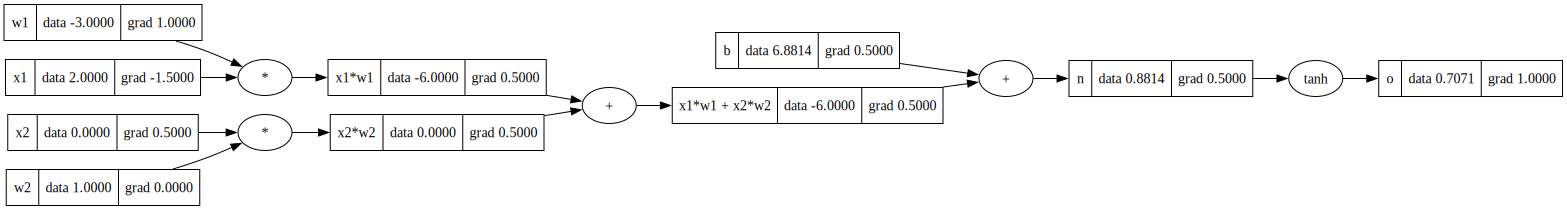

In [6]:
draw_dot(o)

In [7]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()  # Fixed typo from 'tann' to 'tanh'
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs  # Fixed condition and return

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [8]:
x =[2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.5917928166466124, grad=0.0)

In [11]:
draw_dot(MLP)

AttributeError: type object 'MLP' has no attribute '_prev'

In [14]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired tar


In [19]:

for k in range(10):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0.0
    
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.01 * p.grad
        
    print(k, loss.data)

0 1.9307366607141492
1 1.819719659366582
2 1.7086701194519156
3 1.5985599959382841
4 1.4904956524801862
5 1.3856124181025082
6 1.284965435226346
7 1.1894378680386357
8 1.0996817238303802
9 1.0160965289546526


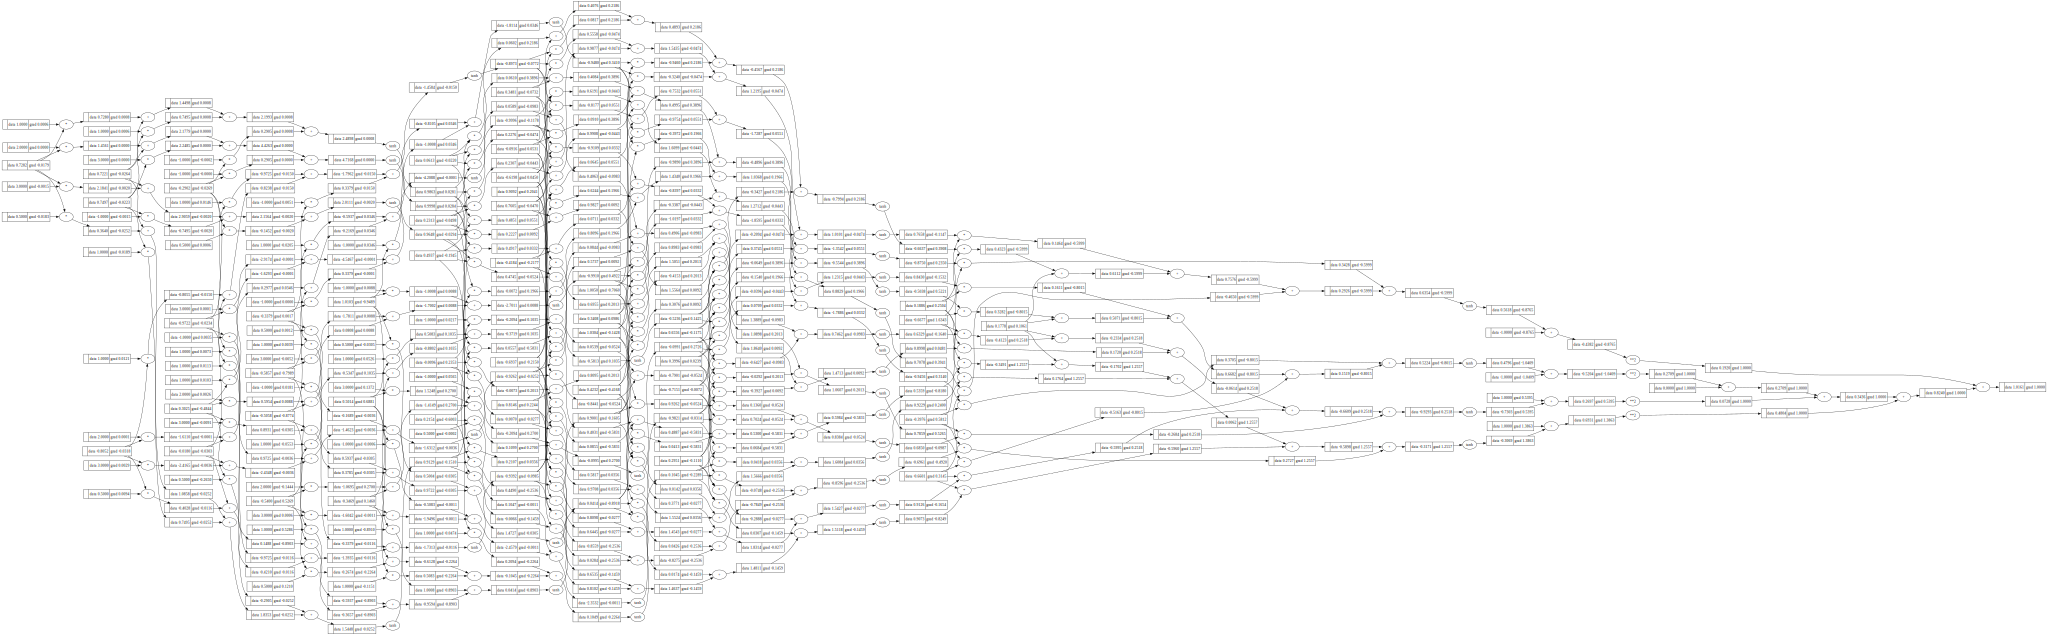

In [22]:
loss
draw_dot(loss)

In [24]:
ypred

TypeError: unhashable type: 'list'

In [13]:
draw_dot(loss)

NameError: name 'loss' is not defined